# Pupil dynamic

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
import pymc as pm
import arviz as az

rng = np.random.default_rng(seed=42)
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.16.1


In [2]:
# Specify HMC conditions to be applied in modelling
ndraws = 2500
ntune  = 2500

In [3]:
group_colors = {
    'male': '#D7301F',  # Vibrant red with an orangish hue (for males)
    'female': '#F4A40B',  # Strong yellow (for females)
    'atoke': '#654321'   # Duller brown (for atokes)
}

#### Pupil dynamic measures from Exeter

scale	0.55	µm is one pixel	
182	pixels = 	100	µm


Feret's diameter:The longest distance between any two points along the selection boundary, also known as maximum caliper.
MinFeret is the minimum caliper diameter. 

In [4]:
# Load the data and exclude times exceeding 35 minutes
eye_measures_um_df = pd.read_csv('../data/Platynereis_eye_pupil.csv', sep = ',')
eye_measures_um_df = eye_measures_um_df[eye_measures_um_df['time'] <= 35]
eye_measures_um_df.tail()

,structure,group,id,date,side,time,area,perimeter,major,minor,feret,minFeret
80,pupil,male,male3,30_08_23,only,0,1495,151.938,46.690,40.769,47.170,40.806
81,pupil,male,male3,30_08_23,only,5,1621,168.977,50.455,40.906,51.865,40.000
82,pupil,male,male3,30_08_23,only,10,1210,140.741,43.085,35.758,45.591,37.000
83,pupil,male,male3,30_08_23,only,20,2593,207.954,62.672,52.679,62.936,51.000
84,pupil,male,male3,30_08_23,only,30,2593,207.954,62.672,52.679,62.936,51.000


In [5]:
# Group by 'id' and calculate the mean for the 'major' column
eye_measures_um_df_grouped = eye_measures_um_df.groupby(['id'])['major'].mean().reset_index()

# Display the grouped DataFrame
eye_measures_um_df_grouped

,id,major
0,atoke1,64.2866
1,atoke2,70.3020
2,atoke3,87.9084
3,female1,110.1192
4,female2,112.2414
5,female3,69.5208
6,male1,45.8864
7,male2,166.8976
8,male3,53.1148


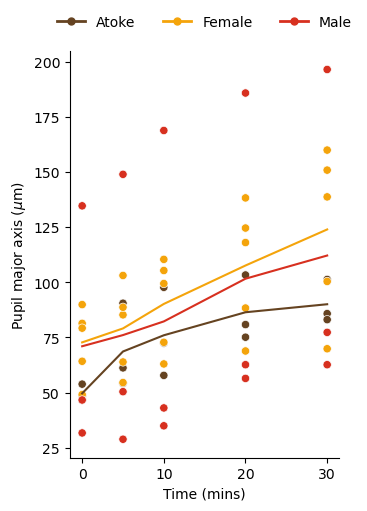

In [6]:
# Ensure 'group' is a categorical variable and matches the group_colors dictionary keys
eye_measures_um_df['group'] = eye_measures_um_df['group'].astype('category')

# Create a relplot with increased width
g = sns.relplot(data=eye_measures_um_df, x='time', y='major', hue='group', height=4.8, aspect=0.75, palette=group_colors)

# Add a lineplot on the relplot using the group_colors dictionary
g.map_dataframe(sns.lineplot, 'time', 'major', hue='group', estimator='mean', err_style=None, palette=group_colors)

# Remove the original legend
g._legend.remove()

# Define custom legend handles using the group_colors palette
legend_handles = [Line2D([0], [0], color=group_colors[group], marker='o', markersize=5, linestyle='-', linewidth=2) for group in ['atoke', 'female', 'male']]

# Add a new legend with custom handles and no outer box
plt.legend(handles=legend_handles, labels=['Atoke', 'Female', 'Male'], loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=3, frameon=False)

# Set axis labels
plt.xlabel('Time (mins)')
plt.ylabel(r'Pupil major axis ($\mu$m)')

# Show the plot
plt.show()


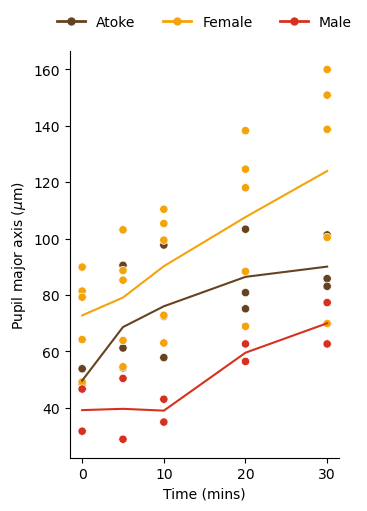

In [7]:
eye_measures_um_df = eye_measures_um_df.loc[eye_measures_um_df['id'] != 'male2'].copy()

# Ensure 'group' is a categorical variable and matches the group_colors dictionary keys
eye_measures_um_df['group'] = eye_measures_um_df['group'].astype('category')

# Create a relplot with increased width
g = sns.relplot(data=eye_measures_um_df, x='time', y='major', hue='group', height=4.8, aspect=0.75, palette=group_colors)

# Add a lineplot on the relplot using the group_colors dictionary
g.map_dataframe(sns.lineplot, 'time', 'major', hue='group', estimator='mean', err_style=None, palette=group_colors)

# Remove the original legend
g._legend.remove()

# Define custom legend handles using the group_colors palette
legend_handles = [Line2D([0], [0], color=group_colors[group], marker='o', markersize=5, linestyle='-', linewidth=2) for group in ['atoke', 'female', 'male']]

# Add a new legend with custom handles and no outer box
plt.legend(handles=legend_handles, labels=['Atoke', 'Female', 'Male'], loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=3, frameon=False)

# Set axis labels
plt.xlabel('Time (mins)')
plt.ylabel(r'Pupil major axis ($\mu$m)')

# Show the plot
plt.show()

In [8]:
#eye_measures_um_df = eye_measures_um_df.copy()
#del eye_measures_um_df
# Convert to micrometers
# If the locale is 'Exeter', factor 'major', 'minor', 'feret', and 'minFeret' by 0.55
eye_measures_um_df[['major', 'minor', 'feret', 'minFeret']] *= 100/182
eye_measures_um_df.tail()

,structure,group,id,date,side,time,area,perimeter,major,minor,feret,minFeret
80,pupil,male,male3,30_08_23,only,0,1495,151.938,25.653846,22.400549,25.917582,22.420879
81,pupil,male,male3,30_08_23,only,5,1621,168.977,27.722527,22.475824,28.497253,21.978022
82,pupil,male,male3,30_08_23,only,10,1210,140.741,23.673077,19.647253,25.050000,20.329670
83,pupil,male,male3,30_08_23,only,20,2593,207.954,34.435165,28.944505,34.580220,28.021978
84,pupil,male,male3,30_08_23,only,30,2593,207.954,34.435165,28.944505,34.580220,28.021978


In [9]:
# Group eye_measures_um_df by locale, time, group and id
# if there are multiple measurements at area, perimeter, major, minor, feret, or minFeret, average them
numeric_cols = eye_measures_um_df.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('time')

# Group by 'locale', 'time', 'group', 'id', 'structure' and calculate mean of numeric columns
eye_measures_um_df = eye_measures_um_df.groupby(['time', 'group', 'id'])[numeric_cols].mean().reset_index()
eye_measures_um_df.head()

C:\Users\seano\AppData\Local\Temp\ipykernel_9860\652681264.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eye_measures_um_df = eye_measures_um_df.groupby(['time', 'group', 'id'])[numeric_cols].mean().reset_index()


,time,group,id,area,perimeter,major,minor,feret,minFeret
0,0,atoke,atoke1,1514.0,151.037,26.625275,21.857143,27.180220,22.005495
1,0,atoke,atoke2,1504.0,158.066,29.600000,19.531319,29.263187,19.419780
2,0,atoke,atoke3,1495.0,151.938,25.653846,22.400549,25.917582,22.420879
3,0,atoke,female1,NaN,NaN,NaN,NaN,NaN,NaN
4,0,atoke,female2,NaN,NaN,NaN,NaN,NaN,NaN


Note that there is great uncertainty in the measurements of the narrowest pupil in the case of a few images, which are not especially sharp.

In [10]:
# Display the first few rows of the dataframe
eye_measures_um_df['W_scaled'] = (eye_measures_um_df['major'] - eye_measures_um_df['major'].mean()) / eye_measures_um_df['major'].std()
eye_measures_um_df['T_scaled'] = (eye_measures_um_df['time'] - eye_measures_um_df['time'].mean()) / eye_measures_um_df['time'].std()
eye_measures_um_df.head()

,time,group,id,area,perimeter,major,minor,feret,minFeret,W_scaled,T_scaled
0,0,atoke,atoke1,1514.0,151.037,26.625275,21.857143,27.180220,22.005495,-0.950574,-1.20198
1,0,atoke,atoke2,1504.0,158.066,29.600000,19.531319,29.263187,19.419780,-0.768171,-1.20198
2,0,atoke,atoke3,1495.0,151.938,25.653846,22.400549,25.917582,22.420879,-1.010140,-1.20198
3,0,atoke,female1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.20198
4,0,atoke,female2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.20198


In [11]:
eye_measures_um_df.describe()

,time,area,perimeter,major,minor,feret,minFeret,W_scaled,T_scaled
count,120.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,1.200000e+02
mean,13.000000,4270.675000,239.363075,42.127720,33.669615,42.985817,33.856456,0.000000,2.960595e-17
std,10.815488,3534.774378,94.659324,16.308505,14.463759,16.688579,14.570802,1.000000,1.000000e+00
min,0.000000,544.000000,87.993000,15.882418,11.984615,15.934066,12.087912,-1.609302,-1.201980e+00
25%,5.000000,1594.250000,166.243250,30.714148,22.457005,31.417170,22.420879,-0.699854,-7.396800e-01
50%,10.000000,3204.500000,238.994250,41.881044,29.684615,43.112912,29.670330,-0.015126,-2.773800e-01
75%,20.000000,5706.125000,288.987125,50.476717,42.037500,51.700275,42.127747,0.511941,6.472200e-01
max,30.000000,15963.000000,486.321000,87.858242,69.839560,88.815934,69.230769,2.804090,1.571820e+00


In [12]:
with pm.Model() as m1:
    # Convert 'Group' to an integer category
    eye_measures_um_df['group'] = eye_measures_um_df['group'].astype('category').cat.codes

    # Priors
    Intercept = pm.Normal('Intercept', mu=0, sigma=1, shape=eye_measures_um_df['group'].nunique())
    Slope = pm.Normal('Slope', mu=0, sigma=1, shape=eye_measures_um_df['group'].nunique())
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model
    mu = Intercept[eye_measures_um_df['group']] + Slope[eye_measures_um_df['group']] * eye_measures_um_df['T_scaled']

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=eye_measures_um_df['W_scaled'])

c:\Users\seano\miniforge3\envs\platynereis\Lib\site-packages\pymc\model\core.py:1366: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


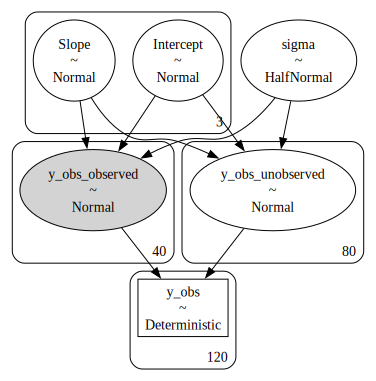

In [19]:
# Need graphviz to view the model
pm.model_to_graphviz(m1)

Sampling: [Intercept, Slope, sigma, y_obs_observed, y_obs_unobserved]


<Axes: xlabel='y_obs_observed'>

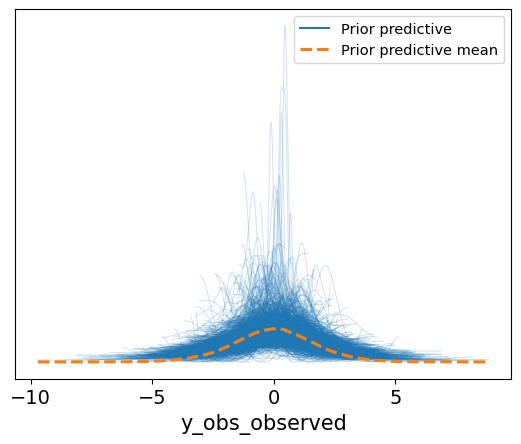

In [14]:
# PRIOR PREDICTIVE CHECK
with m1:
    idata = pm.sample_prior_predictive(samples=1000, random_seed=rng)

az.plot_ppc(idata, group="prior", kind="kde", data_pairs={"y_obs": "y_obs"})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Slope, sigma, y_obs_unobserved]


Output()

Sampling 4 chains for 2_500 tune and 2_500 draw iterations (10_000 + 10_000 draws total) took 84 seconds.
c:\Users\seano\miniforge3\envs\platynereis\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'Slope'}>,
        <Axes: title={'center': 'Slope'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'y_obs'}>,
        <Axes: title={'center': 'y_obs'}>],
       [<Axes: title={'center': 'y_obs_unobserved'}>,
        <Axes: title={'center': 'y_obs_unobserved'}>]], dtype=object)

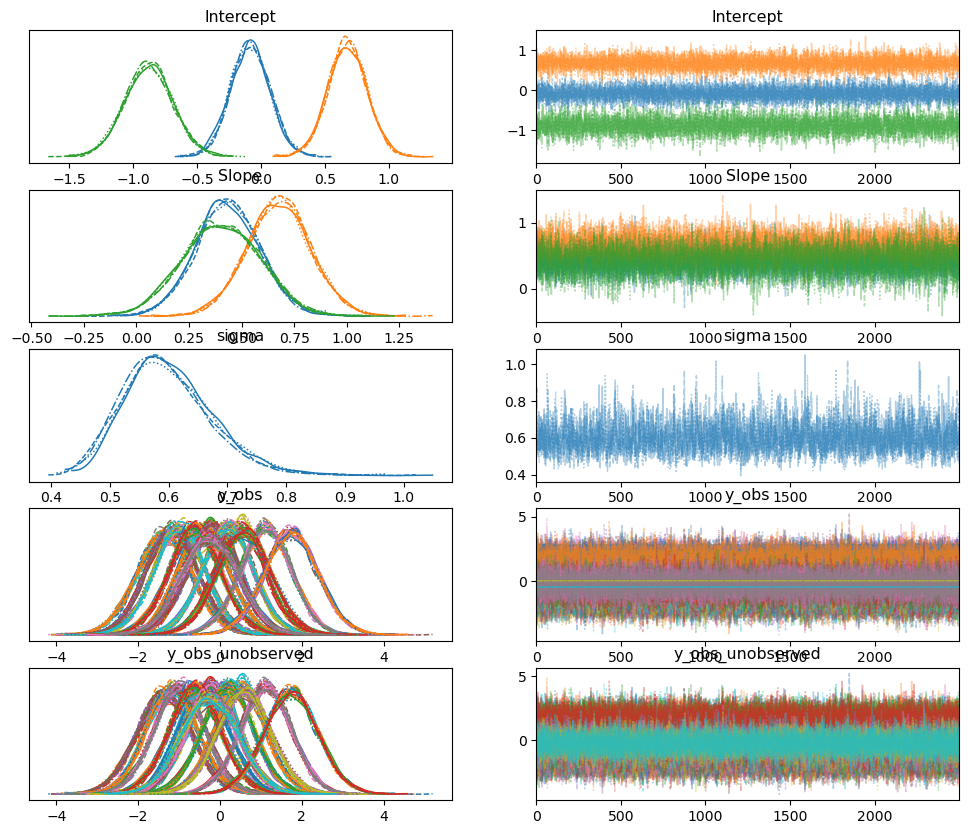

In [15]:
with m1:
    idata.extend(pm.sample(ndraws, tune=ntune, random_seed=rng))

az.plot_trace(idata)

Sampling: [y_obs_observed]


Output()

Sampling: [y_obs_observed]


Output()

<Axes: xlabel='y_obs_observed'>

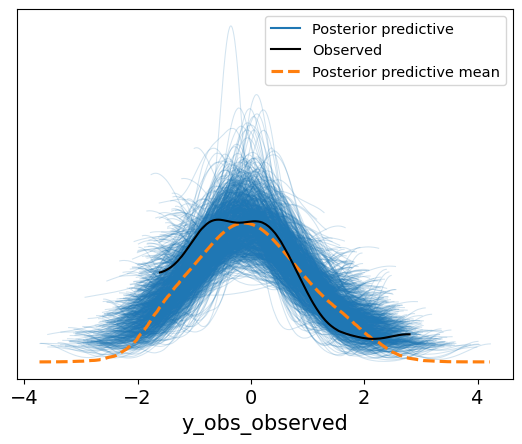

In [16]:
# POSTERIOR PREDICTIVE CHECK
with m1:
   idata.extend(pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng, predictions= True))
   idata.extend(pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng, predictions= False))

az.plot_ppc(idata, group="posterior", kind="kde", data_pairs={"y_obs": "y_obs"}, num_pp_samples=1000)

In [17]:
major_mean = eye_measures_um_df['major'].mean() 
major_std   = eye_measures_um_df['major'].std()

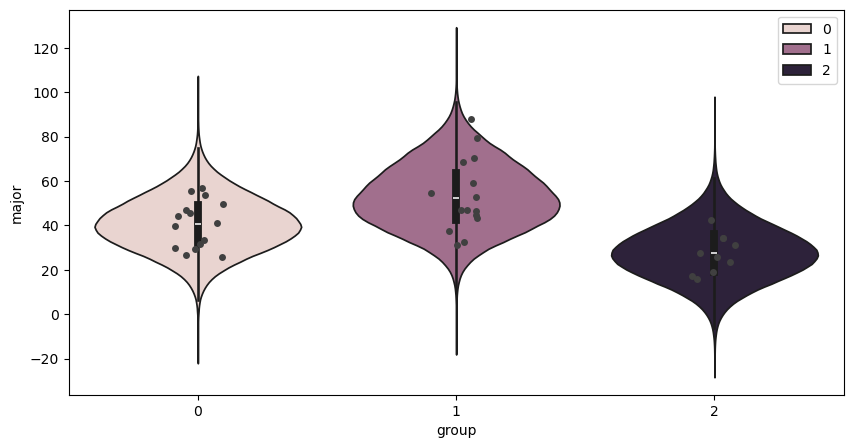

In [18]:
Groups = eye_measures_um_df['group']

# Convert 'y_obs' to a numpy array and reshape to 2 dimensions
y_obs_2d = idata.posterior_predictive['y_obs'].values.reshape(-1, len(Groups))

# Convert posterior predictive samples into a DataFrame
ppc_df = pd.DataFrame(y_obs_2d, columns=Groups)

# Take the mean of the predictions for each 'Group'
ppc_df_mean = ppc_df.groupby(level=0).mean()

# Melt the DataFrame to long format for plotting
ppc_df_melt = ppc_df_mean.melt(var_name='group', value_name='Predicted_W')
ppc_df_melt['major'] = (ppc_df_melt['Predicted_W'] * major_std) + major_mean

# Plot boxplots
plt.figure(figsize=(10, 5))
sns.violinplot(data=ppc_df_melt, x='group', y='major',  hue="group")
sns.stripplot(data=eye_measures_um_df, x="group", y="major", color="0.25")
plt.show()